In [1]:
import os
import time
import numpy as np
import cv2
import random
import colorsys
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import math
%matplotlib inline
from lib.detection import Detect
import pickle
from pynq_dpu import DpuOverlay
import time
import glob

from scipy.special import expit
import serial
from IPython.display import clear_output

In [2]:
# load DPU overlay
overlay = DpuOverlay("dpu.bit")

In [3]:
# load multitask model and other helper variables/classes

overlay.load_model("files/MTV3.xmodel")
dpu = overlay.runner
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()
shapeIn = tuple(inputTensors[0].dims)
shapeOut = []
outputSize = []
outputData = []
for idx, tensor in enumerate(outputTensors):
    shapeOut.append(tensor.dims)
    outputSize.append(tensor.get_data_size()/shapeIn[0])
    outputData.append(np.empty(tensor.dims, dtype=np.float32, order="C"))

with open("files/priors.pckl","rb") as f:
    priors = pickle.load(f)

detect = Detect(5, 0, 200, 0.05, 0.45)
label_colours = cv2.imread('files/cityscapes19.png', 1).astype(np.uint8)

In [4]:
def pre_process(image, model_image_size):
    image = image[...,::-1]
    image_data = np.array(image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) 	
    return image_data

def parse_detection(ranges, output_shape):
    # Parse output tensors for detection 
    tensors = list()
    for i in range(ranges[0],ranges[1]):
        tensors.append(np.reshape(np.reshape(outputData[i],shapeOut[i]),(1,-1)))
    output = np.concatenate(tensors,1)
    output = np.reshape(output,output_shape)
    return output

def process_raw(input_image):
    # Prepare input data variables
    input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
    image = input_data[0]

    image_size = input_image.shape[:2]

    # Preprocess input image and add it to the input data
    image_data = np.array(pre_process(input_image, (320, 512)), dtype=np.float32)
    image[0,...] = image_data.reshape(shapeIn[1:])

    start_job = time.time()
    # Execute model inference using DPU
    job_id = dpu.execute_async(input_data, outputData)
    dpu.wait(job_id)
    end_job = time.time()
    
    # Measure process time
    print(f"DPU process time: {end_job - start_job}, FPS: {1/(end_job - start_job)}")

    # Parse detection results into locations, confidence data and centerness data
    loc_ori = parse_detection((16,23),(1,-1,4))
    conf_data = parse_detection((9,16),(1,-1,5))
    centerness_data = parse_detection((2,9),(1,-1,1))

    # Get confidence scores
    confidence = expit(conf_data) * expit(centerness_data)
    
    # Parse detections using Vitis AI provided code
    detections = detect.forward(loc_ori, confidence, priors)

    # Convert detection tensor into bounding boxes with scores
    count = 0
    final_dets = []
    for j in range(detections.shape[1]):
        dets = detections[0, j, :]
        
        feature_dim = dets.shape[1]

        mask = dets[:, 0].__gt__(0.)
        dets_bck = []

        for k in range(mask.shape[0]):
            if mask[k]:
                dets_bck.append(dets[k,:])
        dets = np.asarray(dets_bck)
        dets = dets.reshape(-1, feature_dim)
        if dets.ndim == 0:
            continue
        boxes = dets[:, 1:5].copy()
        scores = dets[:, 0].copy()
        final_dets.append((boxes, scores))
        count = count + 1

    # Parse raw lane, drivable area and object segmentation
    lane_raw = outputData[0][0,...]
    seg_raw = outputData[1][0,...]
    driv = outputData[24][0,...]

    return final_dets, lane_raw, seg_raw, driv    

def process(input_image, debug = False):
    # List of available detection classes
    BBOX_NAMES = ['human', 'light_yellow', 'light_green', 'light_red', 'obstacle']
    
    # Process image and measure raw processing time
    start = time.time()
    final_dets, lane_raw, seg_raw, driv = process_raw(input_image)
    end = time.time()
    
    print(f"MultiTask V3 process with pre and post processing: {end - start}, FPS: {1/(end - start)}")

    input_image = cv2.resize(input_image, (512,320))

    # Parse more bounding boxes info
    bboxes = []
    count = 0
    for boxes, scores in final_dets:
        for num in range(len(boxes[:, 0])):
            # Use only boxes with > 55% confidence score
            if scores[num] > 0.55:
                p1 = (int(boxes[num, 0]), int(boxes[num, 1]))
                p2 = (int(boxes[num, 2]), int(boxes[num, 3]))
                cent = (int(abs(p1[0]-p2[0])),int(abs(p1[1]-p2[1])))
                size = cent[0]*cent[1]
                pcent = (cent[0]//2+min(p1[0],p2[0]),cent[1]//2+min(p1[1],p2[1]))
                bbox_info = {"center":pcent,"size":size,"type":BBOX_NAMES[count]}
                bboxes.append(bbox_info)
                
                if debug:
                    # Draw predicted bounding boxes on input image if in debug mode
                    cv2.rectangle(input_image, p1, p2, (0, 0, 255), 2)
                    p3 = (max(p1[0], 20), max(p1[1], 20))
                    title = "%s" % (BBOX_NAMES[count])
                    cv2.putText(input_image, title, p3, cv2.FONT_ITALIC, 0.9, (0, 0, 255), 2)
        count += 1

    # Resize drivable data tensor
    driv = driv[:,:,1]
    driv = cv2.resize(driv, (512,320))

    # Resize segmentation data tensor
    seg_data = seg_raw.argmax(2)
    seg_stack =  np.dstack([seg_data, seg_data, seg_data]).astype(np.uint8)

    if debug:
        # If debugging is used - convert colors to CityScapes style
        seg = cv2.LUT(seg_stack,label_colours)
    else:
        seg = seg_stack

    # Resize lane data tensor
    lane_data = lane_raw[:,:,1]
    lane = expit(lane_data)

    return input_image, seg, driv, lane, bboxes

def find_lanes(lane,lane_dbg):
    # Prepare default falues. "len":-1 means that no left lanes were found
    lane_info = {"len":-1,"angle":0,"stop":0,"end":(0,0)}
    
    # Binarize segmentation, setting 0.25 as confidence score
    lane_bin = np.zeros(lane.shape)
    lane_bin[lane>0.25]=255
    
    # Get edges of binarized segmentation using Canny's algorithm
    edges = cv2.Canny(np.uint8(lane_bin), 75, 100)

    # Find lines from edges using Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 45, None, 50, 20)

    if lines is not None:
            # Prepare data for found left lane
            leftlinedict = {
                 "ln": [],
                 "ang": [],
                 "x": [],
                 "y": []
            }
            for i in range(0, len(lines)):
                l = lines[i][0]
                # Get starting and ending points of found lines
                x1, y1, x2, y2 = lines[i][0]
                
                # Measure how much of examined lane fits in vertical ROI, compared to its width.
                # This way we can exclude lanes that are only partially in the ROI
                stop_angle = np.abs(min(400,max(100,x1))-min(400,max(100,x2)))/np.abs(x1-x2)
                
                # If y axis difference is small - lane is horizontal. Additionaly check if lane fits in ROI
                # This way we exclude vertical lanes found far away or above the ground
                if abs(y1 - y2) < 10 and min(y1,y2) > 175 and stop_angle>0.5:                   
                    if(min(y1,y2) > 220):
                        # If lane fits in ROI - robot should stop
                        lane_info["stop"]=1
                        if lane_dbg.any():
                            # Draw stop lane in red if in debugging mode
                            cv2.line(lane_dbg, (x1, y1), (x2, y2), (255, 0, 0), 3, cv2.LINE_AA)
                    elif lane_dbg.any():
                        # Draw vertical lane in blue if in debugging mode
                        cv2.line(lane_dbg, (x1, y1), (x2, y2), (0, 0, 255), 1, cv2.LINE_AA)


                # Check if lane fits in ROI
                elif max(y1,y2)>230 and min(x1,x2)<125:
                    # Measure line's length
                    lngth = np.sqrt(np.square(x1-x2)+np.square(y1-y2))
                    # To avoid dividing by 0, set angle to a high number
                    if np.abs(x1-x2) != 0:
                        angle = np.abs(y1-y2) / np.abs(x1-x2)
                    else:
                        angle = 10e3
                    # Collect line's info and append it to dict
                    leftlinedict["ln"].append(lngth)
                    leftlinedict["ang"].append(angle)

                    leftlinedict["x"].append(min(x1,x2))
                    leftlinedict["y"].append(max(y1,y2))

                elif lane_dbg.any():
                    # if in debug mode - draw all lines that are not considered as stop or left lane
                    cv2.line(lane_dbg, (x1, y1), (x2, y2), (0, 0, 255), 1, cv2.LINE_AA)

            if len(leftlinedict["ln"]) and not lane_info["stop"]:
                # Get max length of lane and mean angle. Append it to results
                lngth = np.max(leftlinedict["ln"])
                angle = np.mean(leftlinedict["ang"])
                
                lane_info["len"]=lngth
                lane_info["angle"]=angle
                
                # Calculate starting and ending position of combined lines
                startx = int(np.mean(leftlinedict["x"]))
                starty = int(np.mean(leftlinedict["y"]))
                X = lngth/np.sqrt(1+np.square(angle))
                Y = angle * X
                endx = int(startx + X)
                endy = int(starty - Y)
                
                # Save end point of found lane
                lane_info["end"]= (endx,endy)
                if lane_dbg.any(): 
                    # if in debug mode - draw combined lines in green
                    cv2.line(lane_dbg, (startx, starty), (endx, endy), (0, 255, 0), 3, cv2.LINE_AA)

    if lane_dbg.any():
        # plot drawn lanes on debug picture if in debug mode
        plt.imshow(lane_dbg)
        plt.gray()
        plt.show()

    return lane_info

def procedures(dev, procedure):
    # Print car's movement procedure
    print(f"PROCEDURE: {procedure}")

    # Check if device is available (not in debug mode). If so- proceed with procedure.
    # There are some predefined movement procedures, calculated on the mock-up for our car.
    # Kria KV260 sends Vx, Vy and omega vectors for set speed via serial USB to motor controller
    # which handles motor control. 
    if dev:
        SPEED = 8
        if procedure == "overtake":
            dev.write(f"0,12,0\n".encode())
            time.sleep(1)
            dev.write(f"{SPEED},0,0\n".encode())
            time.sleep(1.6)
            dev.write(f"0,-12,0\n".encode())
            time.sleep(1)
            dev.write(f"{SPEED},0,0\n".encode())
        elif procedure == "stop":
            dev.write("0,0,0\n".encode())
        elif procedure == "turn_left":
            dev.write(f"{SPEED},0,0\n".encode())
            time.sleep(0.35)
            dev.write("0,0,7\n".encode())
            time.sleep(1.35)
            dev.write(f"{SPEED//2},0,0\n".encode())
        elif procedure == "turn_right":
            dev.write(f"{SPEED},0,0\n".encode())
            time.sleep(1.4)
            dev.write(f"8,0,-4\n".encode())
            time.sleep(2.1)
            dev.write(f"{SPEED},0,0\n".encode())
            time.sleep(2)
        elif procedure == "forward":
            dev.write(f"{SPEED},0,0\n".encode())
        elif procedure == "slow_down":
            dev.write(f"{SPEED//2},0,0\n".encode())
            time.sleep(3)
        

def main(img, dev, debug=False):
    try:
        print("===================================================")

        # Process input image
        input_image, seg, driv,  lane, bboxes = process(img, debug = debug)
        
        if debug:
            # If in debug mode - plot results of input image, detection and segmentations
            input_image = cv2.cvtColor(input_image,cv2.COLOR_RGB2BGR)
            lane_debug = np.zeros_like(input_image)
            lane_debug[driv>0.5]=(128,128,128)
            lane_debug[lane>0.15]=(255,255,255)
            driv2 = np.zeros_like(input_image)
            driv2[driv>0.5]=(128,128,128)
            row1 = np.hstack((input_image, seg))
            row2 = np.hstack((driv2, lane_debug))

            final = np.vstack((row1,row2))
            plt.imshow(final)
            plt.show()
        else:
            # If not in debug mode, initialize lane_debug as empty array.
            # This way find_lanes() function can detect if it is in debug mode.
            lane_debug=np.empty(0)

        if len(bboxes):
            # Iterate through bounding boxes
            for bbox in bboxes:
                size = bbox["size"]
                center = bbox["center"]
                
                if bbox["type"]=="human":
                    if size >= 16000:
                        # If obstacle was detected and its size suggests it is close to the car,
                        # start stop procedure and skip further analysis of current frame
                        procedures(dev,"stop")
                        return
                
                if bbox["type"]=='obstacle':
                    if size >= 4000:
                        if center[1] > 210:
                            # If obstacle was detected and it fits in ROI,
                            # start overtake procedure and skip further analysis of current frame
                            procedures(dev,"overtake")
                            return
                
        # Call find_lanes() function and get results
        lane_info = find_lanes(lane,lane_debug)

        # If stop lane was found - pass through it slowly with slow_down procedure
        if lane_info["stop"]:
            procedures(dev,"slow_down")
            return

        # If left lane was found, but its length is less than 110 - car is near intersection or
        # curved road. It should decide where to turn.
        if -1< lane_info["len"] < 110:
            # Check how much of drivable area is available on car's left side, starting from the
            # ending point of found lane
            drivable_left=(driv[:lane_info["end"][1],:lane_info["end"][0]]>0.5).sum()
            isdrivable = drivable_left / (lane_info["end"][0]*lane_info["end"][1])
            
            # Depending of result, proceed with turning left or right
            if isdrivable > 0.1:
                procedures(dev,"turn_left")
            else:
                procedures(dev,"turn_right")
            return

        elif lane_info["len"] == -1:
            # If for some reason no left lane was found in this frame,
            # check how much of drivable area is available in front of the car
            drivable_fwd=(driv[100:150,200:400]>0.5).sum()
            isdrivable = drivable_fwd / (149*199)
            
            # If there is no visible drivable area, car should stop to try and get data from 
            # the new frame
            if isdrivable < 0.1:
                procedures(dev,"stop")
                return
        
        # If none of procedures were triggered - car can continue moving forward
        procedures(dev,"forward")

    except KeyboardInterrupt:
        raise KeyboardInterrupt


DPU process time: 0.07320904731750488, FPS: 13.659513907660042
MultiTask V3 process with pre and post processing: 0.14284181594848633, FPS: 7.000751099108362


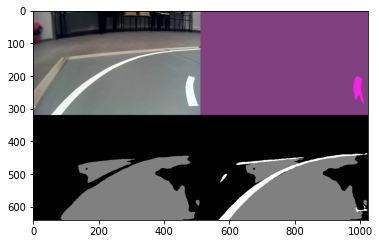

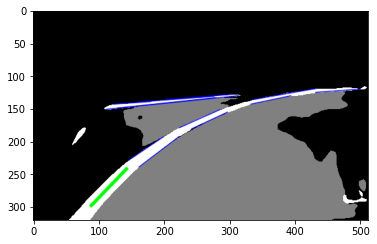

PROCEDURE: turn_right
DPU process time: 0.07318568229675293, FPS: 13.663874799242906
MultiTask V3 process with pre and post processing: 0.14023971557617188, FPS: 7.130647662051519


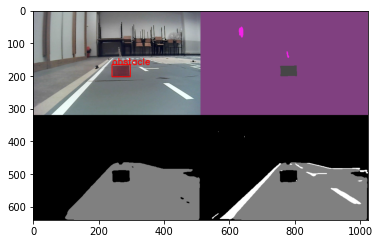

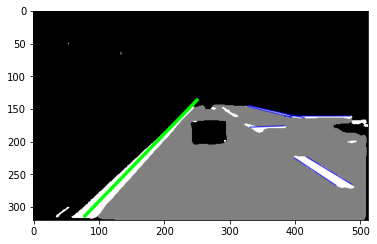

PROCEDURE: forward
DPU process time: 0.07313156127929688, FPS: 13.673986750821554
MultiTask V3 process with pre and post processing: 0.1230161190032959, FPS: 8.12901600296143


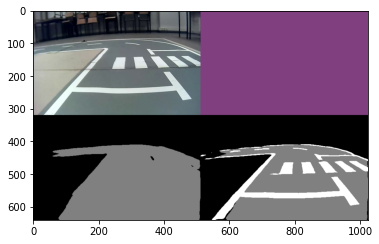

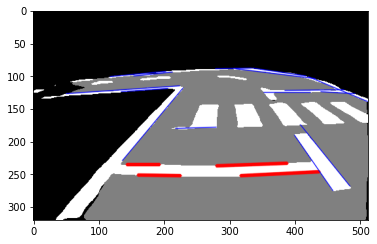

PROCEDURE: slow_down
DPU process time: 0.07294893264770508, FPS: 13.7082197601072
MultiTask V3 process with pre and post processing: 0.12272787094116211, FPS: 8.14810843153482


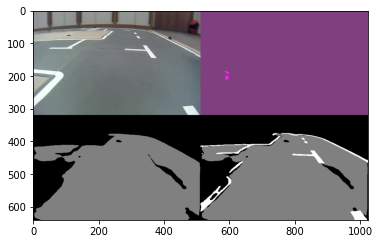

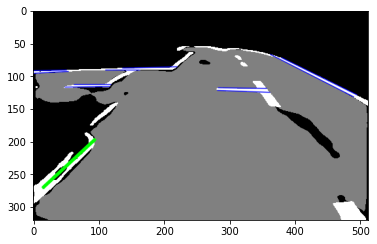

PROCEDURE: turn_left
DPU process time: 0.0731360912322998, FPS: 13.673139802122215
MultiTask V3 process with pre and post processing: 0.12701916694641113, FPS: 7.872827574297475


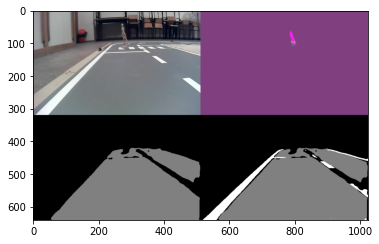

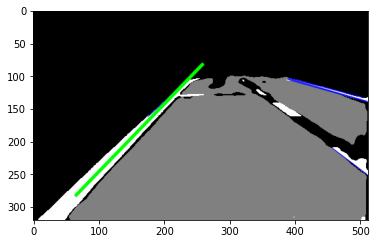

PROCEDURE: forward
DPU process time: 0.07311248779296875, FPS: 13.677554001878326
MultiTask V3 process with pre and post processing: 0.13068723678588867, FPS: 7.651856635689292


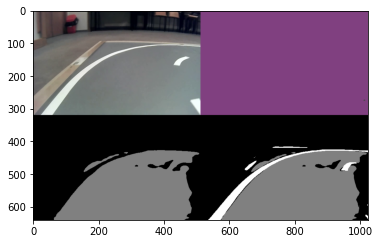

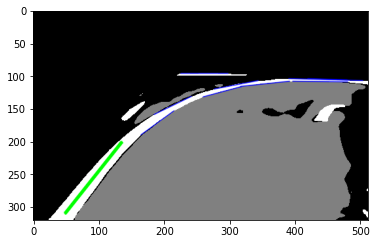

PROCEDURE: forward
DPU process time: 0.0732884407043457, FPS: 13.64471655269784
MultiTask V3 process with pre and post processing: 0.12331748008728027, FPS: 8.109150456952502


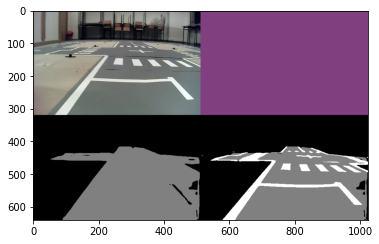

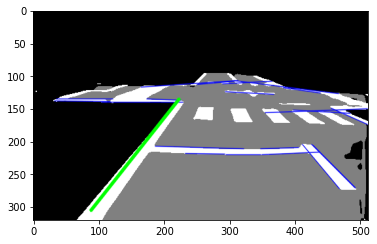

PROCEDURE: forward
DPU process time: 0.07315206527709961, FPS: 13.670154030675766
MultiTask V3 process with pre and post processing: 0.14630556106567383, FPS: 6.835010184958853


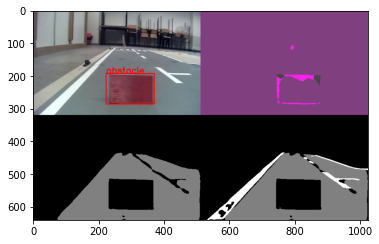

PROCEDURE: overtake
DPU process time: 0.07287812232971191, FPS: 13.721539030270911
MultiTask V3 process with pre and post processing: 0.1321108341217041, FPS: 7.569401908996902


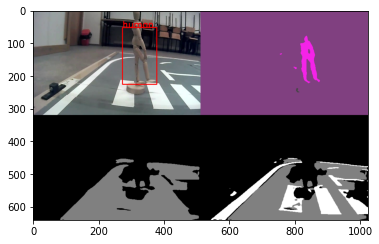

PROCEDURE: stop


In [5]:
DEMO = True

if DEMO:
    # For demo mode prepared pictures are loaded. No additional USB devices are initialized.
    dev = None
    pics = ['img_01050.png','test_makieta.jpg','test_makieta4.jpg','img_00301.jpg',
            'img_01250.png','img_02539.png','img_02575.png','img_00793.png','img_04346.png']
    for path in list(glob.glob('demo/*')):
        img = cv2.resize(cv2.imread(path),(512,320))
        main(img,dev,debug=True)
else:
    # Prepare USB camera and motor driver
    videoIn = cv2.VideoCapture(0 + cv2.CAP_V4L2)
    videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, 512)
    videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, 320)
    videoIn.set(cv2.CAP_PROP_BUFFERSIZE, 1)
    dev = serial.Serial('/dev/serial/by-id/usb-Arduino_LLC_Arduino_Nano_Every_85B4DF415153543553202020FF190F4E-if00',
                        115200, timeout=0.050)

    while True:
        try:
            # If not in demo mode, additionaly measure time of full step of algorithm
            start = time.time()
            ret, frame_vga = videoIn.read()
            img = cv2.resize(frame_vga,(512,320))
            
            main(img,dev,debug = False)
            end = time.time()
            print(f"Full proces: {end - start}, FPS: {1/(end - start)}\n\n")

        except KeyboardInterrupt:
            # Stop the car if Kernel was interrupted
            print("Stopping")
            procedures(dev,"stop")
            videoIn.release()
            break

In [12]:
del overlay
del dpu